In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
import tensorflow as tf
import gensim

Using TensorFlow backend.


In [2]:
df = pd.read_csv("3000tweet/3000tweet.csv", sep=';',encoding="utf8")
df[:10]

,tweet,durum
0,dun Turkcelle tepkilerimizden sonra bugün Turk...,1
1,girmezmiyim.. Turkcell kartim bile var.. Yarin...,1
2,tam tünelden gecerken 3g cekiyordu :D türkcell...,1
3,turkcell superonline fiber internet veya ADSL ...,1
4,bence Gnçtrkcll Ark Winterfest 2012'de 1.olur ...,1
5,turkcell sana kıyak geçiyor :D,1
6,Turkcelle bağlan hayata diyorum ;))),1
7,"Kimse takmıyo beni yaaaaa, turkcell bana mesaj...",1
8,Bu Turkcell pusula uygulaması iPhone kullanıcı...,1
9,o zaman sorun yok bende turkcell için iyi bir ...,1


In [3]:
df.isna().sum() # Checking for NaN values

tweet    1
durum    0
dtype: int64

In [4]:
df.dropna(inplace=True)

In [5]:
df.isna().sum() # Checking for NaN values

tweet    0
durum    0
dtype: int64

In [6]:
stop = set(stopwords.words('turkish'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [7]:
# Remove punctuations and numbers
def remove_punctuations(text):
    return re.sub('[^\w\s]', ' ', text)

#Single character removal
def remove_single_character(text):
    return re.sub(r"\b[\w\s]\b", ' ',text)

#Removing multiple spaces
def removing_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = remove_punctuations(text)
    text = remove_single_character(text)
    text = removing_multiple_spaces(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text.lower()
 
#number silersek doğruluk değeri yükselir mi? dene

In [8]:
df['tweet']=df['tweet'].apply(denoise_text)

In [9]:
df[:10]

,tweet,durum
0,dun turkcelle tepkilerimizden sonra bugün turk...,1
1,girmezmiyim turkcell kartim bile var yarindan ...,1
2,tam tünelden gecerken 3g cekiyordu türkcell in...,1
3,turkcell superonline fiber internet adsl sabit...,1
4,bence gnçtrkcll ark winterfest 2012 olur gelir,1
5,turkcell sana kıyak geçiyor,1
6,turkcelle bağlan hayata diyorum,1
7,kimse takmıyo beni yaaaaa turkcell bana mesaj ...,1
8,turkcell pusula uygulaması iphone kullanıcılar...,1
9,zaman sorun yok bende turkcell iyi bir tarife ...,1


In [10]:
words = []
for i in df.tweet.values:
    l = []
    for j in i.split():
        l.extend(i.split())
        break
    words.append(l)

In [11]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 500

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 3 , min_count = 1,workers=16)

In [12]:
len(w2v_model.wv.vocab)

12001

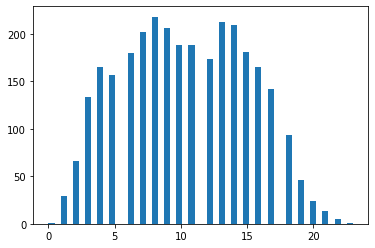

In [13]:
plt.hist([len(j) for j in words], bins = 50)
plt.show()

In [14]:
tokenizer = text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 75)

In [15]:
vocab_size = len(tokenizer.word_index) + 1

In [16]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [17]:
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [18]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=75, trainable=True))
#LSTM 
model.add(LSTM(units=128))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 75, 500)           6001000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               322048    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 6,323,177
Trainable params: 6,323,177
Non-trainable params: 0
_________________________________________________________________


In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, df.durum , test_size = 0.3 , random_state = 0) 

In [22]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 5)

D:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2099 samples, validate on 900 samples
Epoch 1/5
2099/2099 [==============================] - 8s 4ms/step - loss: -3.0888 - acc: 0.2349 - val_loss: -9.1268 - val_acc: 0.2656
Epoch 2/5
2099/2099 [==============================] - 7s 3ms/step - loss: -13.0992 - acc: 0.2463 - val_loss: -15.5533 - val_acc: 0.2656
Epoch 3/5
2099/2099 [==============================] - 7s 3ms/step - loss: -17.8895 - acc: 0.2463 - val_loss: -18.7653 - val_acc: 0.2656
Epoch 4/5
2099/2099 [==============================] - 7s 3ms/step - loss: -20.9350 - acc: 0.2463 - val_loss: -21.4298 - val_acc: 0.2656
Epoch 5/5
2099/2099 [==============================] - 7s 4ms/step - loss: -23.7257 - acc: 0.2463 - val_loss: -23.8999 - val_acc: 0.2656
